<ins>Logical Workflow PA Project</ins>

0. Call Data from SQL Server and save to local .pkl. Filter by TBM 1 and time span ('2022/02/01', '2022/04/01')
1. Join data for a complete dataset
2. Initial Filter (by Equipment ID: TBM 1 and remove Trial Recipes), key generation, cycle time generation and EDA
3. Left Merge Alarm mapping and Alarm hisroy on Created Key.
4. Alarm Discovery: Alarm to GT allocation: Calculate PAAP start and finish times if needed. Do NOT Filter alarms by Type e.g.  FF, CF and MC, assin name in#dexes. Link these alarm name indexes that are occurring for the same green tire at those times identified as PA. Create GT to Alarm Index Mapping.
5. One Hot encode Alarm Indexes before we carry out feature selction to see relevant alarms.
6. Feature selection: Initial Filter using statistical univariate filter methods. 
7. Feature selection: Narrow down using ML Models. Identify which steps are posing the issue (i.e. is it sidewall, inner liner, is it transport time etc.)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from matplotlib.pyplot import figure
import seaborn as sns

In [2]:
import matplotlib
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [3]:
alarm_list = [392, 522, 524, 269, 398, 399, 529, 531, 532, 915, 918, 407, 920, 925, 797, 927, 929, 931, 806, 681, 683, 687, 815, 816, 434, 52, 949, 438, 951, 53, 566, 692, 183, 184, 58, 59, 697, 573, 186, 313, 704, 65, 708, 965, 968, 855, 217, 219, 220, 221, 867, 228, 996, 870, 999, 748, 876, 1005, 1006, 368, 113, 114, 369, 889]

In [4]:
ohe = pd.read_pickle("./pkl/alarm_OHE.pkl")

Take subset as required alarms

In [5]:
shortened_ohe = ohe[alarm_list]
shortened_ohe['Id'] = ohe['Id']
shortened_ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP'] = ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP']
ohe = shortened_ohe

<ipython-input-5-ebd837dbb4d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortened_ohe['Id'] = ohe['Id']
<ipython-input-5-ebd837dbb4d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortened_ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP'] = ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP']


In [6]:
ohe

,392,522,524,269,398,399,529,531,532,915,...,876,1005,1006,368,113,114,369,889,Id,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141586,3.987
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141590,3.993
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141591,3.898
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141640,3.994
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141641,3.893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12464393,3.910
110213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12464394,3.911
110214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12464395,3.907
110215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12464396,3.913


In [7]:
#Loading the dataset columns
X = ohe.drop(["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP", 'Id'],1)   #Feature Matrix
y = ohe["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"]          #Target Variable
ohe.head()

<ipython-input-7-486b4cf30a58>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = ohe.drop(["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP", 'Id'],1)   #Feature Matrix


,392,522,524,269,398,399,529,531,532,915,...,876,1005,1006,368,113,114,369,889,Id,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141586,3.987
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141590,3.993
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141591,3.898
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141640,3.994
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141641,3.893


## Wrapper Method:
A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria. This means, you feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.
There are different wrapper methods such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE. We use Backward Elimination and RFE here.

## Backward Elimination
Feed all the possible features to the model at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.
The performance metric used here to evaluate feature performance is [pvalue](https://www.statsdirect.com/help/basics/p_values.htm). If the pvalue is above 0.05 then we remove the feature, else we keep it.

Here we are using OLS model which stands for “Ordinary Least Squares”. This model is used for performing linear regression.

In [8]:
len(list(X.columns))

64

In [9]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X).fit()
model.pvalues

392    8.088119e-120
522    8.652990e-255
524     0.000000e+00
269     4.972549e-28
398     6.432360e-45
           ...      
368     7.284616e-32
113     1.936569e-36
114     3.189167e-14
369     5.476706e-53
889     1.951978e-06
Length: 64, dtype: float64

In [10]:
len(model.pvalues.values)

64

As we can see that the Alarm __ has highest pvalue of 0.6681452 which is greater than 0.05. Hence we will remove this feature and build the model once again. This is an iterative process and can be performed at once with the help of loop.

In [11]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values,index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>2e-03):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

[392, 522, 524, 269, 398, 399, 529, 531, 532, 918, 407, 920, 925, 927, 931, 681, 687, 815, 434, 438, 951, 53, 692, 183, 184, 58, 59, 697, 573, 186, 313, 65, 708, 965, 968, 855, 217, 219, 220, 221, 867, 228, 996, 870, 748, 1006, 368, 113, 114, 369, 889]


## RFE (Recursive Feature Elimination)
The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

we need to find the optimum number of features, for which the accuracy is the highest. We do that by using loop starting with 1 feature and going up to 22 (for 22 alarms). We then take the one for which the accuracy is highest.

In [13]:
#no of features
nof_list=np.arange(1,64)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f'We now feed {nof} as number of features to RFE and get the final set of features given by RFE method')

c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning:

Optimum number of features: 62
Score with 62 features: 0.430839
We now feed 62 as number of features to RFE and get the final set of features given by RFE method


In [13]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Int64Index([524, 269, 529, 531, 532, 918, 920, 929, 931, 806, 681, 692, 951,
            184, 697, 965, 968, 220, 870, 999, 113],
           dtype='int64')


c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=21 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [15]:
alarm_list = [524, 269, 529, 531, 532, 915, 918, 920, 925, 927, 929, 931, 806, 681, 683, 692, 951, 184, 697, 965, 968, 855, 220, 870, 999, 1005, 1006, 113]
list1 = [524, 269, 529, 531, 532, 918, 920, 925, 927, 929, 931, 806, 692, 951, 184, 697, 965, 968, 855, 220, 870, 999, 1006, 113]
list2 = [524, 269, 529, 531, 532, 918, 920, 929, 931, 806, 681, 692, 951, 184, 697, 965, 968, 220, 870, 999, 113]
len(alarm_list)

28

Lets take a less lossy appraoch, and use the distinct alarms returned form both methods

In [16]:
alarm_list = list(set([524, 269, 529, 531, 532, 918, 920, 925, 927, 929, 931, 806, 692, 951, 184, 697, 965, 968, 855, 220, 870, 999, 1006, 113, 524, 269, 529, 531, 532, 918, 920, 929, 931, 806, 681, 692, 951, 184, 697, 965, 968, 220, 870, 999, 113]))
len(alarm_list)

25

We have eliminated 3 alarms

# Embedded Method
Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [17]:
ohe = pd.read_pickle("./pkl/alarm_OHE.pkl")

In [18]:
shortened_ohe = ohe[alarm_list]
shortened_ohe['Id'] = ohe['Id']
shortened_ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP'] = ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP']
ohe = shortened_ohe

<ipython-input-18-ebd837dbb4d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortened_ohe['Id'] = ohe['Id']
<ipython-input-18-ebd837dbb4d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortened_ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP'] = ohe['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP']


In [20]:
#Loading the dataset columns
X = ohe.drop(["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP", 'Id'],1)   #Feature Matrix
y = ohe["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP"]          #Target Variable
ohe.head()

<ipython-input-20-486b4cf30a58>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = ohe.drop(["VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP", 'Id'],1)   #Feature Matrix


,524,269,529,531,532,918,920,925,927,929,...,965,968,855,220,870,999,1006,113,Id,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141586,3.987
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,11141590,3.993
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141591,3.898
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141640,3.994
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11141641,3.893


In [21]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.002008
Best score using built-in LassoCV: 0.359850


In [22]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 25 variables and eliminated the other 0 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

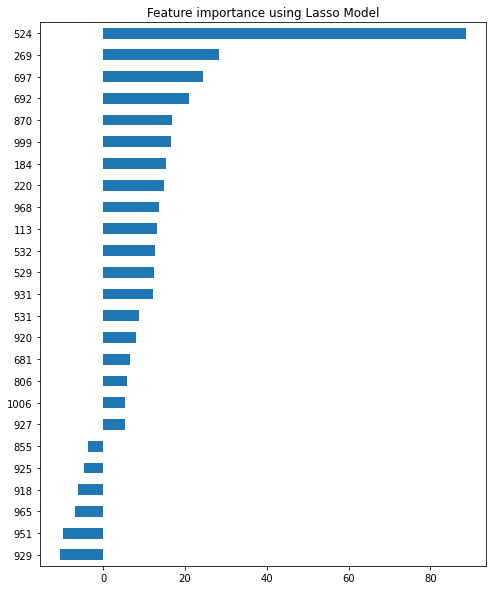

In [23]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [24]:
imp_coef

929    -10.602950
951     -9.763145
965     -6.843425
918     -6.228265
925     -4.798508
855     -3.839794
927      5.240341
1006     5.404883
806      5.759800
681      6.603318
920      7.926628
531      8.611755
931     12.174995
529     12.385456
532     12.733414
113     13.189970
968     13.721199
220     14.940704
184     15.332463
999     16.500135
870     16.821547
692     20.989434
697     24.324601
269     28.270806
524     88.672325
dtype: float64

In [34]:
alarm_list = [931, 529, 532, 113, 968, 220, 184, 999, 870, 692, 697, 269, 524]